## Series Temporales - Trabajo Práctico
### Alumna: Ariadna Garmendia

### Tema: Análisis de cantidad de pasajeros que pasaron por los molinetes del subte en la Ciudad Autónoma de Buenos Aires entre 2017 y 2019.

### COMBINACIÓN DE TRANSFORMACIÓN + DIFERENCIACIÓN PARA CALCULO DE MODELOS

#### Combinación 1: Suavizado con mediana móvil + diferenciación

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import seaborn as sns
from scipy.stats import boxcox 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller, acf, kpss, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scripts.import_data import data


In [4]:
molinetes, rolling_median, difference, de_trend = data()

In [5]:
# Aplico Transformación Logarítmica y luego diferenciación
smoothed = pd.DataFrame(rolling_median.result_30.iloc[30:])
difference['diff_smoothed'] = smoothed.diff()
difference['diff_smoothed'] = difference.diff_smoothed.diff(7)

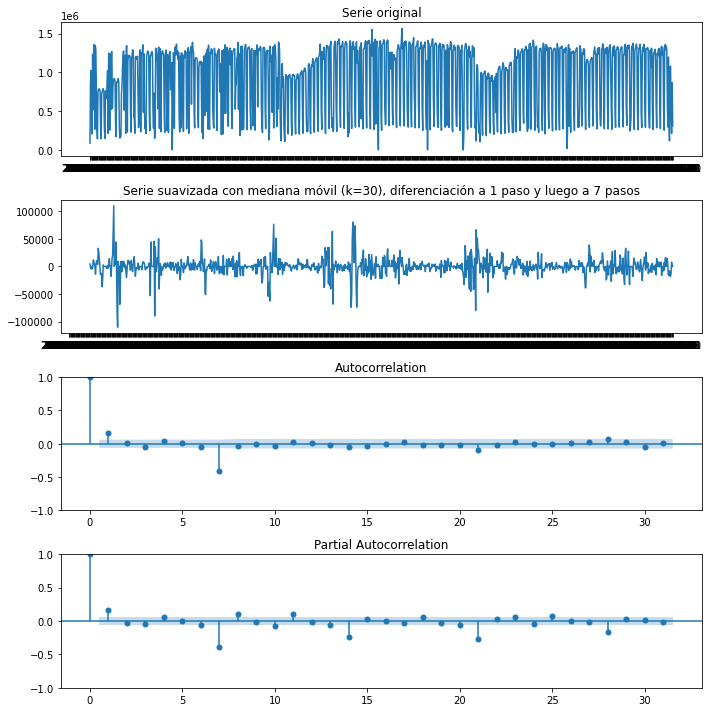

In [6]:
fig, ax = plt.subplots(4,1,figsize=(10,10))
ax[0].plot(molinetes)
ax[0].set_title('Serie original')
ax[1].plot(difference.diff_smoothed)
ax[1].set_title('Serie suavizada con mediana móvil (k=30), diferenciación a 1 paso y luego a 7 pasos')
sm.graphics.tsa.plot_acf(difference.diff_smoothed[38:], ax=ax[2], zero=True)
sm.graphics.tsa.plot_pacf(difference.diff_smoothed[38:], method='ywm', ax=ax[3], zero=True)
plt.tight_layout()
plt.show()

#### Combinación 2: Resto tendenca cíclica (período 7) y diferencio a 7 pasos

In [7]:
difference['diff_comb2'] = de_trend.resultado.diff(periods=7)

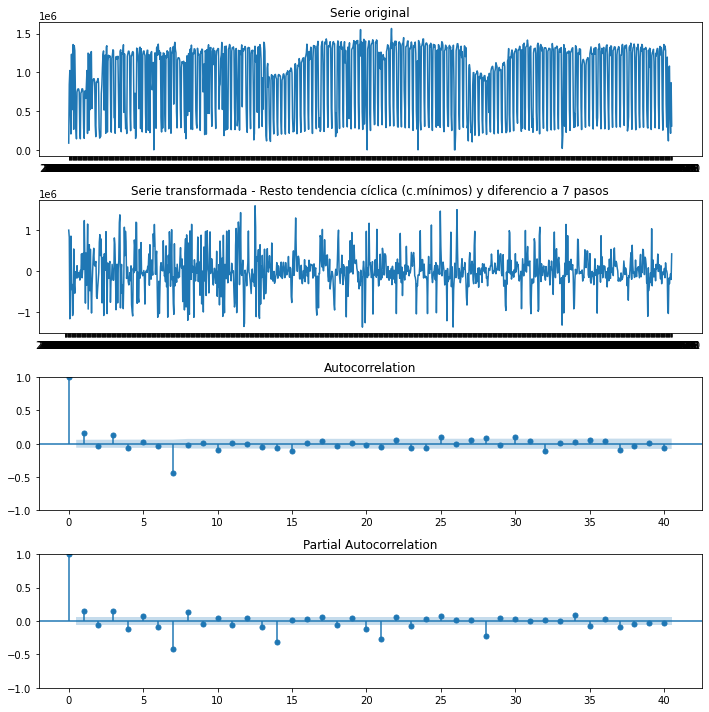

In [8]:
fig, ax = plt.subplots(4,1,figsize=(10,10))
ax[0].plot(molinetes)
ax[0].set_title('Serie original')
ax[1].plot(difference.diff_comb2)
ax[1].set_title('Serie transformada - Resto tendencia cíclica (c.mínimos) y diferencio a 7 pasos')
sm.graphics.tsa.plot_acf(difference.diff_comb2[7:], lags=40, ax=ax[2])
sm.graphics.tsa.plot_pacf(difference.diff_comb2[7:], method='ywm', lags=40, ax=ax[3])
plt.tight_layout()
plt.show()

#### SIGUIENTE PASO - PROBAR MODELOS

#### Estimo modelo usando la serie suavizada con mediana móvil (k = 30) y diferenciada a 1 paso y luego a 7 pasos

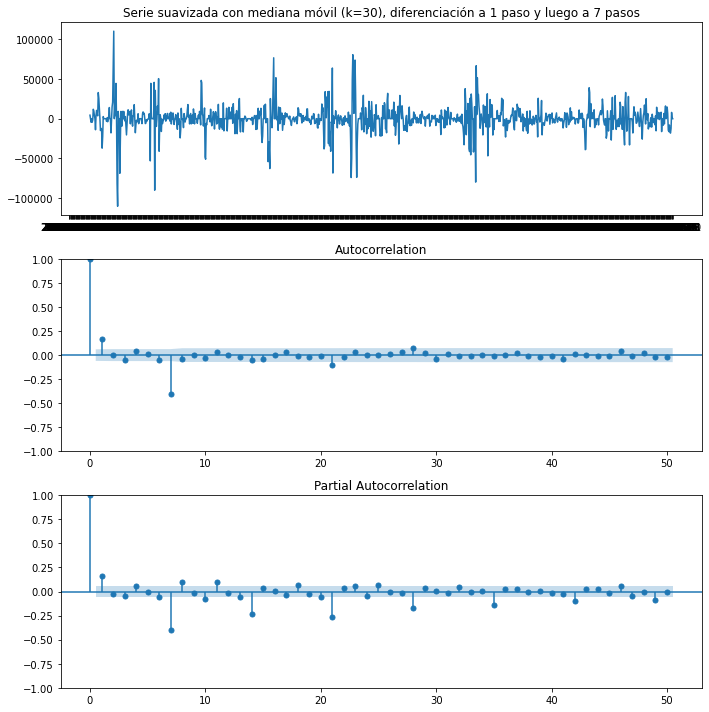

In [9]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(difference.diff_smoothed)
ax[0].set_title('Serie suavizada con mediana móvil (k=30), diferenciación a 1 paso y luego a 7 pasos')
sm.graphics.tsa.plot_acf(difference.diff_smoothed[38:], ax=ax[1], lags=50)
sm.graphics.tsa.plot_pacf(difference.diff_smoothed[38:], method='ywm', ax=ax[2], lags=50)
plt.tight_layout()
plt.show()

#### Primer modelo propuesto:
* Mirando la Autocorrelación, considero para la parte MA, un q=1
* Mirando la Autocorrelación Parcial, veo para la parte AR, un p=1
* d=1, porque diferencié una vez a 1 paso
* Componentes estacionales:
    * D=1 porque diferencié una vez a 7 pasos
    * Q=0 porque no veo componentes desde el lag 8 en adelante
    * P=1 
    * s=7

In [10]:
# Creo una función para evaluar los modelos
def evaluate_model(series, my_order, my_seasonal_order):
    
    mod=sm.tsa.statespace.SARIMAX(series, order = my_order, seasonal_order = my_seasonal_order)
    
    result = mod.fit(disp=False)
    print(result.summary())
    
    return mod, result

In [11]:
# order = (AR specification, Integration order, MA specification) = (p,d,q)
# Seasonal_order = (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity) = (P,D,Q,s)
my_order_1 = (1, 1, 1) #(p,d,q)
my_seasonal_order_1 = (1, 1, 0, 7) #(P,D,Q,s)

In [12]:
_, result_1 = evaluate_model(smoothed, my_order_1, my_seasonal_order_1)

/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                          result_30   No. Observations:                 1062
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 7)   Log Likelihood              -11656.089
Date:                            Tue, 04 Oct 2022   AIC                          23320.177
Time:                                    19:11:28   BIC                          23340.019
Sample:                                         0   HQIC                         23327.699
                                           - 1062                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0563      0.406      0.139      0.890      -0.740       0.853
ma.L1         -0.0001      0.407   

#### Este modelo en principio no parece ser bueno, mirando el orden de los valores del std err en relación a los coeficientes y el p_valor del test de Ljung-Box que da 0.

#### Modelo #2:
* Para la parte MA, q=1
* Para la parte AR, p=1
* d=1, porque diferencié una vez
* Componentes estacionales:
    * D=1
    * Q=0
    * P=3
    * s=7

In [13]:
# order = (AR specification, Integration order, MA specification) = (p,d,q)
# Seasonal_order = (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity) = (P,D,Q,s)
my_order_2 = (1, 1, 1) #(p,d,q)
my_seasonal_order_2 = (3, 1, 0, 7) #(P,D,Q,s)

In [14]:
_, result_2 = evaluate_model(smoothed, my_order_2, my_seasonal_order_2)

/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                          result_30   No. Observations:                 1062
Model:             SARIMAX(1, 1, 1)x(3, 1, [], 7)   Log Likelihood              -11609.008
Date:                            Tue, 04 Oct 2022   AIC                          23230.016
Time:                                    19:11:30   BIC                          23259.778
Sample:                                         0   HQIC                         23241.299
                                           - 1062                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0937      0.406      0.231      0.817      -0.702       0.889
ma.L1         -0.0369      0.407   

#### Este modelo parece ser mejor que el anterior desde el punto de vista de AIC y BIC, pero los otros parámetros dan bastante parecidos al modelo anterior, parece tampoco ser bueno

#### Modelo #3:
* Para la parte MA, q=1
* Para la parte AR, p=1
* d=1 
* Componentes estacionales:
    * D=1
    * Q=0
    * P=1
    * s=7

In [15]:
# order = (AR specification, Integration order, MA specification) = (p,d,q)
# Seasonal_order = (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity) = (P,D,Q,s)
my_order_3 = (1, 0, 1) #(p,d,q)
my_seasonal_order_3 = (1, 0, 0, 7) #(P,D,Q,s)

In [16]:
_, result_3 = evaluate_model(smoothed, my_order_3, my_seasonal_order_3)

/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ari/opt/miniconda3/envs/ari-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:99

                                     SARIMAX Results                                      
Dep. Variable:                          result_30   No. Observations:                 1062
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood              -11565.006
Date:                            Tue, 04 Oct 2022   AIC                          23138.011
Time:                                    19:11:31   BIC                          23157.883
Sample:                                         0   HQIC                         23145.542
                                           - 1062                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001   1616.628      0.000       0.999       1.001
ma.L1          0.2022      0.013   

#### Conclusión: De los 3 modelos considerados me quedaría con el Nro 3, que es el que menor AIC y BIC presenta. Además, el p_valor de Ljung-Box es grande (0,92) con lo cual no rechazo el test (que es lo que busco) y se observa buena relación entre el std error y el valor de los coeficientes estimados.